<a href="https://colab.research.google.com/github/Anirudh-Senani/Flipr_Hackathon_7_2020/blob/main/Flipr_ML_hackathon_7_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

In [2]:
!git clone https://github.com/Anirudh-Senani/Flipr_Hackathon_7_2020/

fatal: destination path 'Flipr_Hackathon_7_2020' already exists and is not an empty directory.


# Loading and Examining Train Data

In [2]:
# Loading sheet 'Train_Data' from Data.xlsx into train_data pandas DataFrame 
train_data = pd.read_excel("/content/Flipr_Hackathon_7_2020/Data.xlsx",sheet_name='Train_Data', index_col = "PLAYER")
train_data.head()

,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,2019_Runs
PLAYER,,,,,,,,,,,,,
Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,0,6,8,160
AB de Villiers,12,11,2,480,90*,53.33,275,174.54,0,6,39,30,424
Abhishek Sharma,3,3,2,63,46*,63,33,190.90,0,0,3,5,63
Ajinkya Rahane,15,14,1,370,65*,28.46,313,118.21,0,1,39,5,396
Alex Hales,6,6,0,148,45,24.66,118,125.42,0,0,13,6,165


In [3]:
# examine data types 
train_data.dtypes

Mat            int64
Inns           int64
NO             int64
2018_Runs      int64
HS            object
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
2019_Runs      int64
dtype: object

# Cleaning Train Data

In [4]:
# found mixed data types in 'HS' column i.e., some numbers are denoted with '*'
# the end representing not out.
# Removing incosistencies in 'HS' column using regex operations to remove non-digits from string.  
train_data.HS = train_data.HS.astype('str').str.replace(r'[^\d.]+', '').astype('int64')

In [5]:
train_data.dtypes

Mat            int64
Inns           int64
NO             int64
2018_Runs      int64
HS             int64
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
2019_Runs      int64
dtype: object

In [6]:
# found missing values in 'Avg' column replacing them with corresponding '2018_Runs' column data 
train_data.loc[train_data.Avg == '-', 'Avg'] = train_data['2018_Runs'].loc[train_data.Avg == '-'].copy()
train_data.Avg = train_data.Avg.astype('float64')

In [7]:
train_data.dtypes

Mat            int64
Inns           int64
NO             int64
2018_Runs      int64
HS             int64
Avg          float64
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
2019_Runs      int64
dtype: object

#Feature Selection & Representing Train Data

PLAYER
Aaron Finch          0
AB de Villiers       0
Abhishek Sharma      0
Ajinkya Rahane       0
Alex Hales           0
                    ..
Virat Kohli          0
Washington Sundar    0
Wriddhiman Saha      0
Yusuf Pathan         0
Yuvraj Singh         0
Name: 100, Length: 100, dtype: int64

AttributeError: ignored

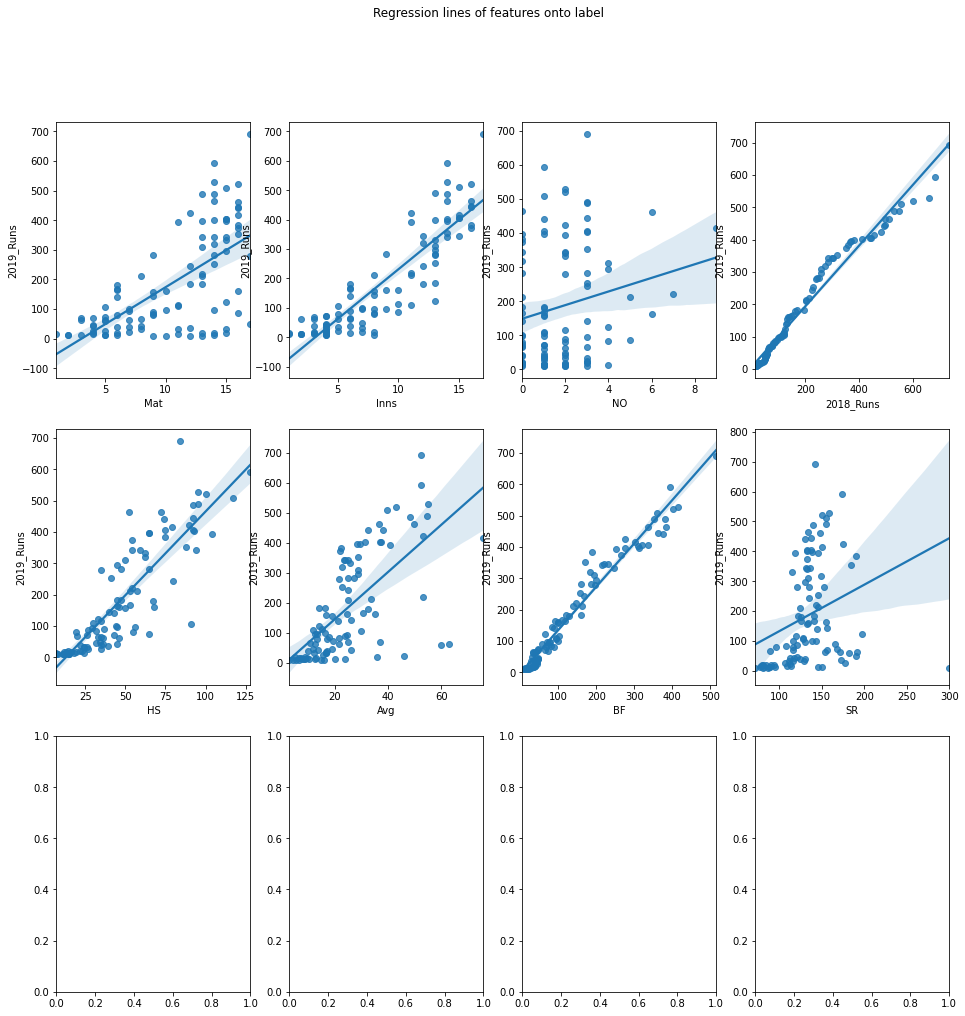

In [102]:
#plotting regreesion lines to all columns on 2019_Runs so we can eliminate redundant features.
features = np.array(train_data.columns[0:12])
features = features.reshape(3,4)
fig, axs = plt.subplots(3,4, figsize = (16,16))
fig.suptitle('Regression lines of features onto label')
for i in range(0,3):
  for j in range(0,4):
    sns.regplot(x = features[i][j], y = '2019_Runs', data= train_data, ax = axs[i, j])

In [ ]:
# NO feature seem to be redundant so proceeding to loading test data 

# Loading and Examining Test Data

In [8]:
# Loading sheet 'Test_Data' from Data.xlsx into test_data pandas DataFrame 
test_data = pd.read_excel("/content/Flipr_Hackathon_7_2020/Data.xlsx", 'Test_Data', index_col= 'PLAYER')
test_data.head()

,Mat,Inns,NO,2019_Runs,HS,Avg,BF,SR,100,50,4s,6s
PLAYER,,,,,,,,,,,,
David Warner,12,12,2,692,100*,69.2,481,143.86,1,8,57,21
KL Rahul,14,14,3,593,100*,53.9,438,135.38,1,6,49,25
Quinton de Kock,16,16,1,529,81,35.26,398,132.91,0,4,45,25
Shikhar Dhawan,16,16,1,521,97*,34.73,384,135.67,0,5,64,11
Andre Russell,14,13,4,510,80*,56.66,249,204.81,0,4,31,52


In [9]:
# examine data types 
test_data.dtypes

Mat            int64
Inns           int64
NO             int64
2019_Runs      int64
HS            object
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
dtype: object

# Cleaning Test Data

In [10]:
# found mixed data types in 'HS' column i.e., some numbers are denoted with '*'
# the end representing not out.
# Removing incosistencies in 'HS' column using regex operations to remove non-digits from string.
test_data.HS = test_data.HS.astype('str').str.replace(r'[^\d.]+', '').astype('int64')

In [11]:
 test_data.dtypes

Mat            int64
Inns           int64
NO             int64
2019_Runs      int64
HS             int64
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
dtype: object

In [12]:
# found missing values in 'Avg' column replacing them with corresponding '2019_Runs' column data 
test_data.loc[test_data.Avg == '-', 'Avg'] = test_data['2019_Runs'].loc[test_data.Avg == '-'].copy()
test_data.Avg = test_data.Avg.astype('float64')

In [13]:
test_data.dtypes

Mat            int64
Inns           int64
NO             int64
2019_Runs      int64
HS             int64
Avg          float64
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
dtype: object

# Making Features and Label pairs for training

In [41]:
# copy train_data to X and '2019_Runs' column to y
X = train_data.copy(deep = True)
y = train_data['2019_Runs'].copy()

In [42]:
# keep only features in X. 
X = X.drop("2019_Runs", axis=1)

In [43]:
X.head()

,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s
PLAYER,,,,,,,,,,,,
Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,0,6,8
AB de Villiers,12,11,2,480,90,53.33,275,174.54,0,6,39,30
Abhishek Sharma,3,3,2,63,46,63.00,33,190.90,0,0,3,5
Ajinkya Rahane,15,14,1,370,65,28.46,313,118.21,0,1,39,5
Alex Hales,6,6,0,148,45,24.66,118,125.42,0,0,13,6


In [46]:
# Removing '2018_Runs' after making a copy to 'tot_runs' column
# because the test set doesn't contain the column name '2018_runs'
# the model considers test set as a different specification and doesn't allow to
# pass test set through the model.
X['tot_runs'] = X['2018_Runs'].copy()
X = X.drop("2018_Runs", axis=1)
X.head()

In [56]:
# Removing '2019_Runs' after making a copy to 'tot_runs' column
# because the train set doesn't contain the column name '2019_runs'
# the model considers train set as a different specification and doesn't allow to
# pass test set through the model.
X_test = test_data.copy(True)
X_test['tot_runs'] = X_test['2019_Runs'].copy()
X_test = X_test.drop('2019_Runs', axis=1)
X_test.head()

# Train, Validation and Test set splitting

In [58]:
# Splitting data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25,random_state=0)

# Normalization of features and labels

In [ ]:
# normalizing makes all features to a specific range
# so no featue is given more or less weightage
# and normalizing labels results in lesser loss so model can improve more.
feature_scaler = MinMaxScaler()
feature_scaler.fit(X_train)

label_scaler = StandardScaler()
label_scaler.fit(y_train)

X_train_norm = feature_scaler.transform(X_train)
X_valid_norm = feature_scaler.transform(X_valid)
X_test_norm  = feature_scaler.transform(X_test)

y_train_norm = label_scaler.transform(y_train)
y_valid_norm = label_scaler.transform(y_valid)

# Specifying Regression Model Architecture and training

In [64]:
# Training a XGBRegressor 
reg_model = XGBRegressor(objective='reg:squarederror', n_estimators=900, learning_rate=0.07)
reg_model.fit(X_train, y_train, 
             early_stopping_rounds= 50, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

# MSE and MAE of regression model
print("Regression model evaluation without normalization") 
print("Training MSE:",mean_squared_error(y_train, reg_model.predict(X_train)))
print("Training MAE:",mean_absolute_error(y_train, reg_model.predict(X_train)))
print("Validation MSE:",mean_squared_error(y_valid, reg_model.predict(X_valid)))
print("Validation MAE:",mean_absolute_error(y_valid, reg_model.predict(X_valid)))

0.3170843177744751
0.31945587793986
668.4819766241377
13.355107307434082


In [ ]:
# MSE and MAE of regression model
print("Regression model evaluation with normalization") 
print("Training MSE:",mean_squared_error(y_train_norm, reg_model.predict(X_train_norm)))
print("Training MAE:",mean_absolute_error(y_train_norm, reg_model.predict(X_train_norm)))
print("Validation MSE:",mean_squared_error(y_valid_norm, reg_model.predict(X_valid_norm)))
print("Validation MAE:",mean_absolute_error(y_valid_norm, reg_model.predict(X_valid_norm)))

# Specifying NN Model Architecture and Training

In [ ]:
#Training a NN model with 2 hidden layers,MSE loss function and SGD optimizer 
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(144, 'relu', input_dim = 12),
    #tf.keras.layers.Dense(500, 'relu'),
    tf.keras.layers.Dense(1)                                
])

In [ ]:
nn_model.compile(optimizer=SGD(0.01, 0.8),loss = 'MSE')
nn_model.fit(X, y, epochs = 1000, validation_split=0.1)

Epoch 1/1000
3/3 [==============================] - 0s 49ms/step - loss: 37513.7852 - val_loss: 1199.9047
Epoch 2/1000
3/3 [==============================] - 0s 11ms/step - loss: 4321.0137 - val_loss: 14127.6826
Epoch 3/1000
3/3 [==============================] - 0s 10ms/step - loss: 8994.9375 - val_loss: 4734.3374
Epoch 4/1000
3/3 [==============================] - 0s 11ms/step - loss: 1500.2681 - val_loss: 610.8182
Epoch 5/1000
3/3 [==============================] - 0s 10ms/step - loss: 2176.4045 - val_loss: 2789.4331
Epoch 6/1000
3/3 [==============================] - 0s 12ms/step - loss: 3190.0959 - val_loss: 1284.7399
Epoch 7/1000
3/3 [==============================] - 0s 11ms/step - loss: 1429.0521 - val_loss: 454.6246
Epoch 8/1000
3/3 [==============================] - 0s 11ms/step - loss: 687.7255 - val_loss: 1911.0442
Epoch 9/1000
3/3 [==============================] - 0s 11ms/step - loss: 1330.3446 - val_loss: 2051.1462
Epoch 10/1000
3/3 [==============================] - 0s 

In [ ]:
# MSE and MAE of NN model
print("NN model evaluation without normalization") 
print("Training MSE:",mean_squared_error(y_train, nn_model.predict(X_train)))
print("Training MAE:",mean_absolute_error(y_train, nn_model.predict(X_train)))
print("Validation MSE:",mean_squared_error(y_valid, nn_model.predict(X_valid)))
print("Validation MAE:",mean_absolute_error(y_valid, nn_model.predict(X_valid)))

55.76833175135871


In [ ]:
# MSE and MAE of NN model
print("NN model evaluation with normalization") 
print("Training MSE:",mean_squared_error(y_train_norm, nn_model.predict(X_train_norm)))
print("Training MAE:",mean_absolute_error(y_train_norm, nn_model.predict(X_train_norm)))
print("Validation MSE:",mean_squared_error(y_valid_norm, nn_model.predict(X_valid_norm)))
print("Validation MAE:",mean_absolute_error(y_valid_norm, nn_model.predict(X_valid_norm)))

#Comparison B/w Regreesion and NN Model

In [ ]:
# plot showing the original and predictions of both models 

In [ ]:
# after comparison decide the final model based on which is close to original
final_model = nn_model

# Hyperparameter Tuning

In [ ]:
# tune the hyperparameters in the final model for more better results.
GridSearchCV

# Making predictions on Test data and Display Result

In [77]:
# making predictions on test data
predictions = pd.Series(final_model.predict(X_test), index= test_data.index)

PLAYER
David Warner         528.209656
KL Rahul             528.218079
Quinton de Kock      475.008881
Shikhar Dhawan       464.288879
Andre Russell        443.650055
                        ...    
Carlos Brathwaite      9.450233
Ishant Sharma         10.711971
Shakib Al Hasan        9.751990
Pawan Negi             9.253675
Tim Southee            9.751990
Length: 100, dtype: float32

# Export the Result 

In [78]:
# Exporting the final result into a csv file
test_data['2020_Runs'] = predictions.astype('int64')
test_data

,Mat,Inns,NO,2019_Runs,HS,Avg,BF,SR,100,50,4s,6s,2020_Runs
PLAYER,,,,,,,,,,,,,
David Warner,12,12,2,692,100,69.20,481,143.86,1,8,57,21,528
KL Rahul,14,14,3,593,100,53.90,438,135.38,1,6,49,25,528
Quinton de Kock,16,16,1,529,81,35.26,398,132.91,0,4,45,25,475
Shikhar Dhawan,16,16,1,521,97,34.73,384,135.67,0,5,64,11,464
Andre Russell,14,13,4,510,80,56.66,249,204.81,0,4,31,52,443
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Carlos Brathwaite,2,2,0,11,6,5.50,10,110.00,0,0,1,0,9
Ishant Sharma,13,3,3,10,10,10.00,3,333.33,0,0,1,1,10
Shakib Al Hasan,3,1,0,9,9,9.00,10,90.00,0,0,0,0,9
